In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [2]:
def load_data(filename):
    data = pd.read_csv(filename, skiprows=6, sep=' ', names=['index', 'x', 'y'], skipfooter=1, engine='python')
    return data.set_index('index')

def euclidean_distance(p1, p2):
    return round(np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2))

def calculate_distance_matrix(coords):
    size = coords.shape[0]
    matrix = np.zeros((size, size), dtype=int)
    coords_values = coords.values
    for i in range(size):
        for j in range(size):
            if i != j:
                matrix[i][j] = euclidean_distance(coords_values[i], coords_values[j])
            else:
                matrix[i][j] = 0
    return matrix

def initialize_two_greedy_cycles(distance_matrix):
    n = len(distance_matrix)
    start1 = random.randint(0, n-1)
    nearest1 = np.argmin([distance_matrix[start1][i] if i != start1 else np.inf for i in range(n)])
    cycle1 = [start1, nearest1, start1]
    visited = set([start1, nearest1])

    distances_to_start1 = [distance_matrix[start1][i] for i in range(n)]
    start2 = np.argmax(distances_to_start1)
    while start2 in visited:
        distances_to_start1[start2] = -np.inf
        start2 = np.argmax(distances_to_start1)
        
    nearest2 = np.argmin([distance_matrix[start2][i] if i != start2 and i not in visited else np.inf for i in range(n)])
    cycle2 = [start2, nearest2, start2]
    visited.update([start2, nearest2])

    return cycle1, cycle2, visited

def calculate_cycle_length(cycle, distance_matrix):
    total_length = 0
    for i in range(len(cycle)):
        total_length += distance_matrix[cycle[i]][cycle[(i + 1) % len(cycle)]]
    return total_length

def plot_cycles(coords, cycle1, cycle2, title = 'Visualization of Two Cycles'):
    x_coords, y_coords = coords['x'].values, coords['y'].values

    plt.figure(figsize=(10, 8))
    
    # Plot cycle1
    x1 = [x_coords[i] for i in cycle1]
    y1 = [y_coords[i] for i in cycle1]
    plt.plot(x1, y1, 'ro-', label='Cycle 1')

    # Plot cycle2
    x2 = [x_coords[i] for i in cycle2]
    y2 = [y_coords[i] for i in cycle2]
    plt.plot(x2, y2, 'bo-', label='Cycle 2')

    plt.scatter(x_coords, y_coords, color='gray', zorder=3)
    
    for i in range(len(x_coords)):
        plt.annotate(str(i), (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()



## Heurystyka z 2-żalem (2-regret)

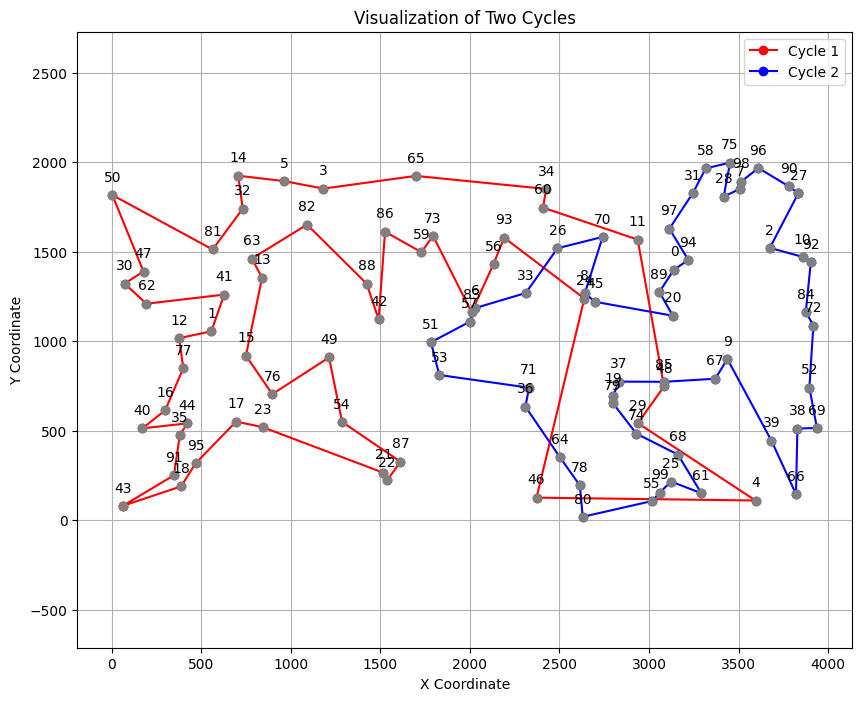

Cycle 1: [43, 18, 95, 17, 23, 21, 22, 87, 54, 49, 76, 15, 13, 63, 82, 88, 42, 86, 59, 73, 83, 56, 93, 24, 46, 4, 29, 48, 11, 60, 34, 65, 3, 5, 14, 32, 81, 50, 47, 30, 62, 41, 1, 12, 77, 16, 40, 44, 35, 91, 43] Length: 18013
Cycle 2: [27, 2, 10, 92, 84, 72, 52, 69, 38, 66, 39, 9, 67, 85, 37, 19, 79, 74, 68, 61, 25, 99, 55, 80, 78, 64, 36, 71, 53, 51, 57, 6, 33, 26, 70, 8, 45, 20, 89, 0, 94, 97, 31, 58, 75, 28, 7, 98, 96, 90, 27] Length: 10510
score: 28523


In [3]:
def insert_with_2_regret(cycle, visited, distance_matrix):
    insertions = []

    for vertex in range(len(distance_matrix)):
        if vertex not in visited:
            insertion_costs = []

            # Only calculate the increase in distance for affected edges (not entire cycle)
            for position in range(len(cycle) - 1):
                # Cost of inserting between cycle[position] and cycle[position + 1]
                cost_increase = (distance_matrix[cycle[position]][vertex] +
                                 distance_matrix[vertex][cycle[position + 1]] -
                                 distance_matrix[cycle[position]][cycle[position + 1]])
                insertion_costs.append((cost_increase, position))

            # Sort the insertion costs to calculate regret
            if len(insertion_costs) >= 2:
                insertion_costs.sort()
                min_cost_1 = insertion_costs[0][0]
                min_cost_2 = insertion_costs[1][0]
                
                # Calculate regret as the difference between the two smallest insertion costs
                regret = min_cost_2 - min_cost_1
                weight = regret - 0.37 * min_cost_1

                # Append the insertion with the weight for regret comparison
                insertions.append((weight, vertex, insertion_costs[0][1]))

    # Sort by highest regret (descending)
    insertions.sort(reverse=True)

    if insertions:
        # Select the insertion with the highest regret
        highest_regret = insertions[0]
        best_vertex = highest_regret[1]
        best_position = highest_regret[2]

        # Insert the best vertex in the best position
        cycle.insert(best_position + 1, best_vertex)
        visited.add(best_vertex)

    return cycle

def expand_cycles_with_2_regret(coords, distance_matrix):
    cycle1, cycle2, visited = initialize_two_greedy_cycles(distance_matrix)
    total_vertices = len(coords)

    while len(visited) < total_vertices:
        if len(visited) < total_vertices:
            cycle1 = insert_with_2_regret(cycle1, visited, distance_matrix)
        if len(visited) < total_vertices:
            cycle2 = insert_with_2_regret(cycle2, visited, distance_matrix)

    return cycle1, cycle2, calculate_cycle_length(cycle1, distance_matrix), calculate_cycle_length(cycle2, distance_matrix)

filename_kroA100 = 'kroA100.tsp'
filename_kroB100 = 'kroB100.tsp'
coords_A = load_data(filename_kroA100)
coords_B = load_data(filename_kroB100)
distance_matrix_A = calculate_distance_matrix(coords_A)
distance_matrix_B = calculate_distance_matrix(coords_B)
cycle1, cycle2, length1, length2 = expand_cycles_with_2_regret(coords_B, distance_matrix_B)
plot_cycles(coords_B, cycle1, cycle2)
print("Cycle 1:", cycle1, "Length:", length1)
print("Cycle 2:", cycle2 , "Length:", length2)
print("score:", length1 + length2)

# Eksperyment obliczeniowy

In [4]:
def run_2_regret_experiments(filename, num_runs=100):
    coords = load_data(filename)
    distance_matrix = calculate_distance_matrix(coords)

    regret_lengths = []
    best_regret_cycle1, best_regret_cycle2 = None, None
    min_regret_length = float('inf')

    for _ in range(num_runs):
        # 2-Regret Heuristic
        cycle1, cycle2, length1, length2 = expand_cycles_with_2_regret(coords, distance_matrix)
        length = length1 + length2
        regret_lengths.append(length)
        if length < min_regret_length:
            min_regret_length = length
            best_regret_cycle1, best_regret_cycle2 = cycle1, cycle2

    regret_stats = (np.mean(regret_lengths), np.min(regret_lengths), np.max(regret_lengths), best_regret_cycle1, best_regret_cycle2, min_regret_length)
    return regret_stats

# Running 2-Regret experiments
filename_kroA100 = 'kroA100.tsp'
filename_kroB100 = 'kroB100.tsp'

regret_stats_A = run_2_regret_experiments(filename_kroA100)
regret_stats_B = run_2_regret_experiments(filename_kroB100)

# Prepare results table
results = {
    'Instance': ['kroA100', 'kroB100'],
    'Method': ['2-Regret', '2-Regret'],
    'Mean': [regret_stats_A[0], regret_stats_B[0]],
    'Min': [regret_stats_A[1], regret_stats_B[1]],
    'Max': [regret_stats_A[2], regret_stats_B[2]]
}

results_df = pd.DataFrame(results)

# Save best cycles for plotting
best_cycles = {
    'kroA100_2Regret': (regret_stats_A[3], regret_stats_A[4], regret_stats_A[5]),
    'kroB100_2Regret': (regret_stats_B[3], regret_stats_B[4], regret_stats_B[5])
}


results_df = pd.DataFrame(results)
results_df

,Instance,Method,Mean,Min,Max
0,kroA100,2-Regret,26338.69,22914,29510
1,kroB100,2-Regret,27757.89,24172,29378


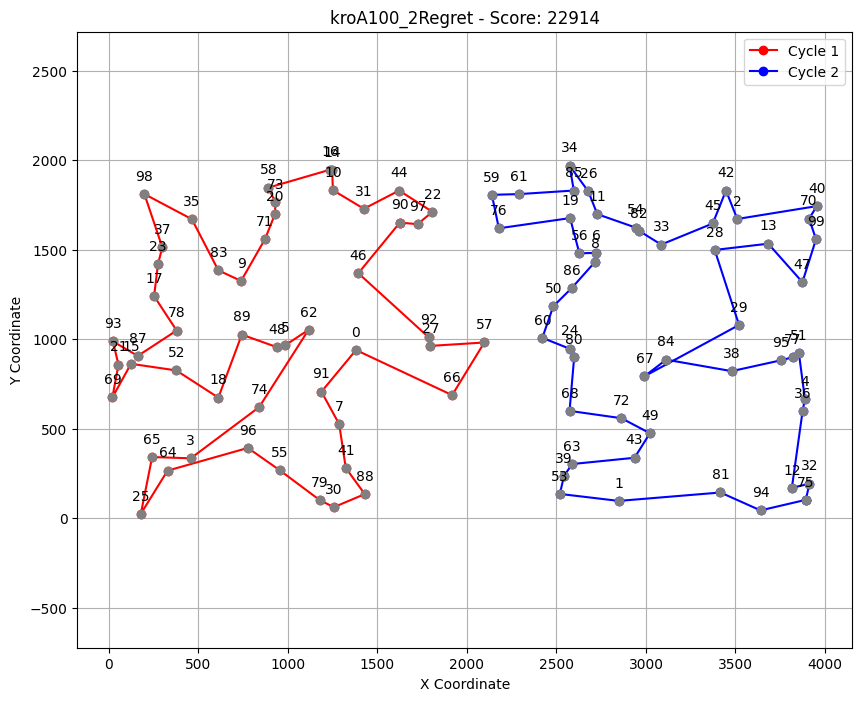

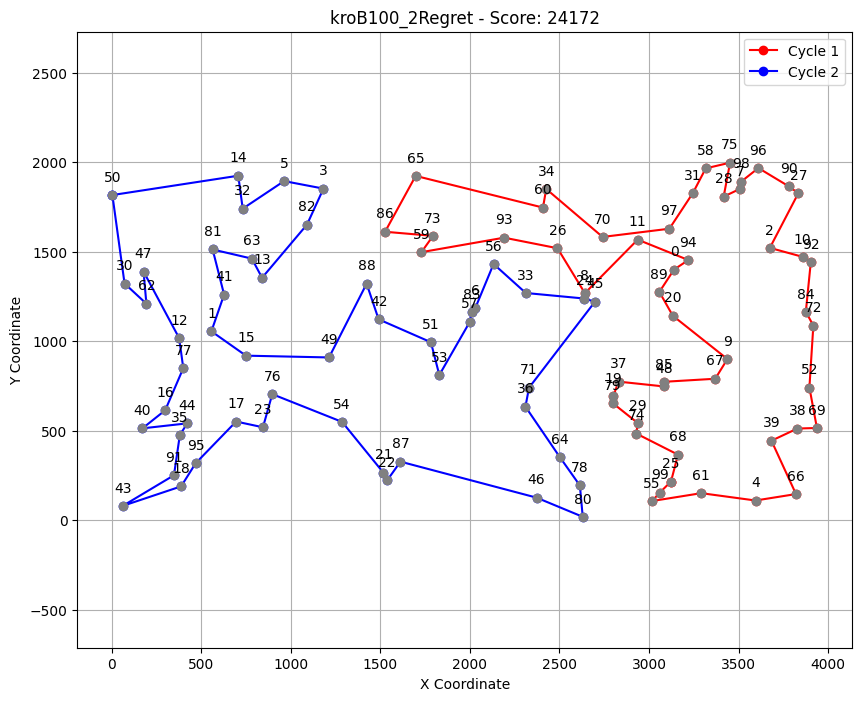

In [5]:
# Plottting best cycles
for instance, cycles in best_cycles.items():
    cycle1, cycle2, score = cycles
    coords = load_data(f'{instance.split("_")[0]}.tsp')
    plot_cycles(coords, cycle1, cycle2, title=f'{instance} - Score: {score}')
    

# Funkcje pomocnicze do local search

In [6]:
def create_random_cycles(distance_matrix):
    num_vertices = len(distance_matrix)
    vertices = list(range(num_vertices))
    random.shuffle(vertices)
    mid = num_vertices // 2
    
    cycle1 = vertices[:mid] + [vertices[0]]
    cycle2 = vertices[mid:] + [vertices[mid]]
    
    return cycle1, cycle2

def calculate_score(cycle1, cycle2, distance_matrix):
    length1 = calculate_cycle_length(cycle1, distance_matrix)
    length2 = calculate_cycle_length(cycle2, distance_matrix)
    return length1 + length2

def swap_between_cycles(cycle1, cycle2, idx1, idx2):
    new_cycle1 = cycle1[:]
    new_cycle2 = cycle2[:]
    new_cycle1[idx1], new_cycle2[idx2] = new_cycle2[idx2], new_cycle1[idx1]
    return new_cycle1, new_cycle2

def delta_swap_vertices_between_cycles(cycle1, cycle2, idx1, idx2, distance_matrix):
    vertex1 = cycle1[idx1]
    vertex2 = cycle2[idx2]

    prev_vertex1 = cycle1[idx1 - 1]
    next_vertex1 = cycle1[(idx1 + 1) % len(cycle1)]  
    prev_vertex2 = cycle2[idx2 - 1]
    next_vertex2 = cycle2[(idx2 + 1) % len(cycle2)]  

    
    original_distance = (distance_matrix[prev_vertex1][vertex1] + 
                         distance_matrix[vertex1][next_vertex1] + 
                         distance_matrix[prev_vertex2][vertex2] + 
                         distance_matrix[vertex2][next_vertex2])

    
    new_distance = (distance_matrix[prev_vertex1][vertex2] + 
                    distance_matrix[vertex2][next_vertex1] + 
                    distance_matrix[prev_vertex2][vertex1] + 
                    distance_matrix[vertex1][next_vertex2])

    delta = new_distance - original_distance
    return delta

def swap_within_cycle(cycle, idx1, idx2):
    new_cycle = cycle[:]
    new_cycle[idx1], new_cycle[idx2] = new_cycle[idx2], new_cycle[idx1]
    return new_cycle

def delta_swap_vertices_within_cycle(cycle, idx1, idx2, distance_matrix):
    if idx1 > idx2:
        idx1, idx2 = idx2, idx1

    
    prev_vertex1 = cycle[idx1 - 1]
    vertex1 = cycle[idx1]
    next_vertex1 = cycle[(idx1 + 1) % len(cycle)]
    prev_vertex2 = cycle[idx2 - 1]
    vertex2 = cycle[idx2]
    next_vertex2 = cycle[(idx2 + 1) % len(cycle)]

    
    if idx2 == idx1 + 1:  
        original_distance = (distance_matrix[prev_vertex1][vertex1] + 
                             distance_matrix[vertex2][next_vertex2])
        
        
        new_distance = (distance_matrix[prev_vertex1][vertex2] + 
                        distance_matrix[vertex1][next_vertex2])
    else:
        original_distance = (distance_matrix[prev_vertex1][vertex1] + 
                             distance_matrix[vertex1][next_vertex1] + 
                             distance_matrix[prev_vertex2][vertex2] + 
                             distance_matrix[vertex2][next_vertex2])
        
        
        new_distance = (distance_matrix[prev_vertex1][vertex2] + 
                        distance_matrix[vertex2][next_vertex1] + 
                        distance_matrix[prev_vertex2][vertex1] + 
                        distance_matrix[vertex1][next_vertex2])

    delta = new_distance - original_distance
    return delta

def swap_edges_in_cycle(cycle, idx1, idx2):
    if idx1 > idx2:
        idx1, idx2 = idx2, idx1
    new_cycle = cycle[:idx1+1] + cycle[idx1+1:idx2+1][::-1] + cycle[idx2+1:]
    return new_cycle

def delta_swap_edges_in_cycle(cycle, idx1, idx2, distance_matrix):
    if idx1 > idx2:
        idx1, idx2 = idx2, idx1

    prev_vertex1 = cycle[idx1]
    next_vertex1 = cycle[(idx1 + 1) % len(cycle)]  
    prev_vertex2 = cycle[idx2]
    next_vertex2 = cycle[(idx2 + 1) % len(cycle)]  

    
    original_distance = (distance_matrix[prev_vertex1][next_vertex1] + 
                         distance_matrix[prev_vertex2][next_vertex2])

    
    new_distance = (distance_matrix[prev_vertex1][prev_vertex2] + 
                    distance_matrix[next_vertex1][next_vertex2])

    delta = new_distance - original_distance
    return delta

def generate_all_vertex_swaps_between_cycles(cycle1, cycle2, distance_matrix):
    possible_swaps = []

    for i in range(len(cycle1) - 1):
        for j in range(len(cycle2) - 1):
            delta = delta_swap_vertices_between_cycles(cycle1, cycle2, i, j, distance_matrix)
            
            if delta < 0:  
                new_cycle1, new_cycle2 = swap_between_cycles(cycle1, cycle2, i, j)
                possible_swaps.append((new_cycle1, new_cycle2, delta))
    
    return possible_swaps

def generate_all_vertex_swaps_within_cycles(cycle1, cycle2, distance_matrix):
    possible_swaps = []

    
    for i in range(len(cycle1) - 1):
        for j in range(i + 1, len(cycle1) - 1):
            delta = delta_swap_vertices_within_cycle(cycle1, i, j, distance_matrix)
            if delta < 0:  
                new_cycle1 = swap_within_cycle(cycle1, i, j)
                possible_swaps.append((new_cycle1, cycle2, delta))

    
    for i in range(len(cycle2) - 1):
        for j in range(i + 1, len(cycle2) - 1):
            delta = delta_swap_vertices_within_cycle(cycle2, i, j, distance_matrix)
            if delta < 0:  
                new_cycle2 = swap_within_cycle(cycle2, i, j)
                possible_swaps.append((cycle1, new_cycle2, delta))
    
    return possible_swaps

def generate_all_edge_swaps_within_cycles(cycle1, cycle2, distance_matrix):
    possible_swaps = []

    
    for i in range(len(cycle1) - 1):
        for j in range(i + 1, len(cycle1) - 1):
            delta = delta_swap_edges_in_cycle(cycle1, i, j, distance_matrix)
            if delta < 0:  
                new_cycle1 = swap_edges_in_cycle(cycle1, i, j)
                possible_swaps.append((new_cycle1, cycle2, delta))

    
    for i in range(len(cycle2) - 1):
        for j in range(i + 1, len(cycle2) - 1):
            delta = delta_swap_edges_in_cycle(cycle2, i, j, distance_matrix)
            if delta < 0:  
                new_cycle2 = swap_edges_in_cycle(cycle2, i, j)
                possible_swaps.append((cycle1, new_cycle2, delta))
    
    return possible_swaps

def generate_all_moves(cycle1, cycle2, distance_matrix):
    possible_moves = []
    possible_moves.extend(generate_all_vertex_swaps_between_cycles(cycle1, cycle2, distance_matrix))
    possible_moves.extend(generate_all_vertex_swaps_within_cycles(cycle1, cycle2, distance_matrix))
    possible_moves.extend(generate_all_edge_swaps_within_cycles(cycle1, cycle2, distance_matrix))
    return possible_moves

def generate_combined_moves_list_1(cycle1, cycle2, distance_matrix):
    possible_moves = []
    possible_moves.extend(generate_all_vertex_swaps_between_cycles(cycle1, cycle2, distance_matrix))
    possible_moves.extend(generate_all_vertex_swaps_within_cycles(cycle1, cycle2, distance_matrix))
    return possible_moves

def generate_combined_moves_list_2(cycle1, cycle2, distance_matrix):
    possible_moves = []
    possible_moves.extend(generate_all_vertex_swaps_between_cycles(cycle1, cycle2, distance_matrix))
    possible_moves.extend(generate_all_edge_swaps_within_cycles(cycle1, cycle2, distance_matrix))
    return possible_moves

def generate_all_moves_random(cycle1, cycle2, distance_matrix):
    possible_moves = []

    
    for i in range(len(cycle1) - 1):
        for j in range(len(cycle2) - 1):
            delta = delta_swap_vertices_between_cycles(cycle1, cycle2, i, j, distance_matrix)
            new_cycle1, new_cycle2 = swap_between_cycles(cycle1, cycle2, i, j)
            possible_moves.append((new_cycle1, new_cycle2, delta))  

    
    for i in range(len(cycle1) - 1):
        for j in range(i + 1, len(cycle1) - 1):
            delta = delta_swap_vertices_within_cycle(cycle1, i, j, distance_matrix)
            new_cycle1 = swap_within_cycle(cycle1, i, j)
            possible_moves.append((new_cycle1, cycle2, delta))  

    
    for i in range(len(cycle2) - 1):
        for j in range(i + 1, len(cycle2) - 1):
            delta = delta_swap_vertices_within_cycle(cycle2, i, j, distance_matrix)
            new_cycle2 = swap_within_cycle(cycle2, i, j)
            possible_moves.append((cycle1, new_cycle2, delta))  

    
    for i in range(len(cycle1) - 1):
        for j in range(i + 1, len(cycle1) - 1):
            delta = delta_swap_edges_in_cycle(cycle1, i, j, distance_matrix)
            new_cycle1 = swap_edges_in_cycle(cycle1, i, j)
            possible_moves.append((new_cycle1, cycle2, delta))  

    
    for i in range(len(cycle2) - 1):
        for j in range(i + 1, len(cycle2) - 1):
            delta = delta_swap_edges_in_cycle(cycle2, i, j, distance_matrix)
            new_cycle2 = swap_edges_in_cycle(cycle2, i, j)
            possible_moves.append((cycle1, new_cycle2, delta))  

    return possible_moves

def steepest_ascent_local_search(cycle1, cycle2, distance_matrix, move_list_generator):
    start_time = time.time()
    best_cycle1, best_cycle2 = cycle1, cycle2
    best_score = calculate_score(best_cycle1, best_cycle2, distance_matrix)  
    
    while True:
        possible_moves = move_list_generator(best_cycle1, best_cycle2, distance_matrix)
        best_delta = 0  
        best_move = None  
        
        
        for new_cycle1, new_cycle2, delta in possible_moves:
            if delta < best_delta:  
                best_delta = delta
                best_move = (new_cycle1, new_cycle2)

        if best_move is not None:
            
            best_cycle1, best_cycle2 = best_move
            best_score += best_delta  
        else:
            
            break
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    return best_cycle1, best_cycle2, best_score, time_taken
    
    return best_cycle1, best_cycle2, best_score, time_taken

def greedy_local_search(cycle1, cycle2, distance_matrix, move_list_generator):
    start_time = time.time()
    
    best_cycle1, best_cycle2 = cycle1, cycle2
    best_score = calculate_score(best_cycle1, best_cycle2, distance_matrix)
    
    while True:
        possible_moves = move_list_generator(best_cycle1, best_cycle2, distance_matrix)
        
        
        if not possible_moves:  
            break
        
        
        if random.random() < 0.5:
            possible_moves.reverse()
        
        start_index = random.randint(0, len(possible_moves) - 1)
        improved = False
        
        for i in range(len(possible_moves)):
            index = (start_index + i) % len(possible_moves)
            new_cycle1, new_cycle2, delta = possible_moves[index]
            if delta < 0:  
                best_cycle1, best_cycle2 = new_cycle1, new_cycle2
                best_score += delta  
                improved = True
                break
        
        if not improved:
            break
        
    end_time = time.time()
    time_taken = end_time - start_time
    
    return best_cycle1, best_cycle2, best_score, time_taken

def randomized_optimization(cycle1, cycle2, distance_matrix, time_limit):
    start_time = time.time()
    end_time = start_time + time_limit
    
    best_cycle1, best_cycle2 = cycle1, cycle2
    best_score = calculate_score(best_cycle1, best_cycle2, distance_matrix)
    
    while time.time() < end_time:
        
        possible_moves = generate_all_moves_random(best_cycle1, best_cycle2, distance_matrix)
        if not possible_moves:
            break
        
        
        random_move = random.choice(possible_moves)
        new_cycle1, new_cycle2, score = random_move
        score = calculate_score(new_cycle1, new_cycle2, distance_matrix)
        if score < best_score:
            best_cycle1, best_cycle2 = new_cycle1, new_cycle2
            best_score = score
    
    time_taken = time.time() - start_time
    
    return best_cycle1, best_cycle2, best_score, time_taken


In [7]:
cycle1, cycle2, _, _ = expand_cycles_with_2_regret(coords_A, distance_matrix_A)
distance_matrix_A = calculate_distance_matrix(coords_A)
results = steepest_ascent_local_search(cycle1, cycle2, distance_matrix_A, generate_combined_moves_list_1)
print(results)

([68, 63, 39, 53, 1, 94, 75, 32, 12, 81, 43, 49, 72, 67, 84, 38, 29, 95, 36, 4, 77, 51, 47, 99, 40, 70, 13, 2, 42, 45, 28, 33, 82, 54, 19, 76, 14, 16, 58, 73, 20, 52, 18, 48, 66, 57, 60, 50, 24, 80, 68], [98, 37, 23, 17, 78, 87, 15, 93, 21, 69, 65, 25, 64, 3, 74, 96, 55, 79, 30, 88, 41, 7, 91, 0, 27, 92, 86, 56, 8, 6, 11, 26, 85, 34, 61, 59, 22, 97, 90, 44, 31, 10, 46, 62, 5, 89, 9, 83, 71, 35, 98], 26090, 0.13208699226379395)


In [8]:
# just to test
# cycle1, cycle2 = best_cycles['kroA100_2Regret'][:2]
cycle1, cycle2, _, _ = expand_cycles_with_2_regret(coords_A, distance_matrix_A)
distance_matrix = calculate_distance_matrix(load_data('kroA100.tsp'))
restults = greedy_local_search(cycle1, cycle2, distance_matrix, generate_combined_moves_list_1)
print(restults)

([43, 81, 12, 32, 75, 94, 1, 53, 39, 63, 68, 80, 24, 86, 50, 60, 66, 48, 18, 52, 83, 73, 58, 16, 14, 76, 19, 54, 82, 33, 28, 45, 42, 2, 13, 70, 40, 99, 47, 51, 77, 4, 36, 95, 29, 38, 84, 67, 72, 49, 43], [98, 37, 23, 17, 78, 93, 87, 15, 21, 69, 65, 25, 64, 3, 74, 96, 55, 79, 30, 88, 41, 7, 91, 0, 92, 27, 57, 56, 8, 6, 11, 26, 85, 34, 61, 59, 22, 97, 90, 44, 31, 10, 46, 62, 5, 89, 9, 71, 20, 35, 98], 26283, 0.16362619400024414)


In [9]:
import time
num_runs = 100 
# Function to run and collect stats, including generating new starting cycles for each run
def run_and_collect_stats(start_type, distance_matrix, data, search_function, move_list_generator=None, time_limit=None):
    scores = []
    times = []  # To store the time taken for each run
    best_cycle1, best_cycle2 = None, None
    best_score = float('inf')
    
    for _ in range(num_runs):
        # Generate new starting cycles for each run
        if start_type == "Random":
            cycle1, cycle2 = create_random_cycles(distance_matrix)
        elif start_type == "2-regret":
            cycle1, cycle2, _, _ = expand_cycles_with_2_regret(data, distance_matrix)

        start_time = time.time()  # Start timer
        
        # Perform the local search with or without a time limit
        if search_function == randomized_optimization:
            new_cycle1, new_cycle2, score, _ = search_function(cycle1, cycle2, distance_matrix, time_limit)
        elif move_list_generator:
            new_cycle1, new_cycle2, score, _ = search_function(cycle1, cycle2, distance_matrix, move_list_generator)
        else:
            new_cycle1, new_cycle2, score, _ = search_function(cycle1, cycle2, distance_matrix)

        end_time = time.time()  # End timer
        elapsed_time = end_time - start_time
        times.append(elapsed_time)  # Log time taken for this run
        
        scores.append(score)
        if score < best_score:
            best_score = score
            best_cycle1, best_cycle2 = new_cycle1, new_cycle2
    
    # Return min/max/mean scores and min/max/mean times
    return (np.min(scores), np.max(scores), np.mean(scores), 
            best_cycle1, best_cycle2, np.min(times), np.max(times), np.mean(times))


# Function to handle experiments with random or 2-regret cycles and log completion status
def run_experiments(data, distance_matrix, instance_name):
    results = []
    best_cycles = {}

    avg_steep_time = None  # To store the average time of Random_Steep
    
    for start_type in ["Random", "2-regret"]:
        for neighborhood, move_list_generator in [("Vertices", generate_combined_moves_list_1), 
                                                  ("Edges", generate_combined_moves_list_2)]:
            # Starting message for Greedy search
            print(f"starting {start_type}_{neighborhood}_Greedy_{instance_name}")
            min_score, max_score, mean_score, best_cycle1, best_cycle2, min_time, max_time, avg_time = \
                run_and_collect_stats(start_type, distance_matrix, data, greedy_local_search, move_list_generator)
            results.append([start_type, neighborhood, "Greedy", min_score, max_score, mean_score, min_time, max_time, avg_time])
            best_cycles[f"{start_type}_{neighborhood}_Greedy_{instance_name}"] = (best_cycle1, best_cycle2)
            print(f"finished {start_type}_{neighborhood}_Greedy_{instance_name}")

            # Starting message for Steepest ascent search
            print(f"starting {start_type}_{neighborhood}_Steep_{instance_name}")
            min_score, max_score, mean_score, best_cycle1, best_cycle2, min_time, max_time, avg_time = \
                run_and_collect_stats(start_type, distance_matrix, data, steepest_ascent_local_search, move_list_generator)
            results.append([start_type, neighborhood, "Steep", min_score, max_score, mean_score, min_time, max_time, avg_time])
            best_cycles[f"{start_type}_{neighborhood}_Steep_{instance_name}"] = (best_cycle1, best_cycle2)
            print(f"finished {start_type}_{neighborhood}_Steep_{instance_name}")
            
            # Store the average time of the random steep runs for later use in randomized optimization
            avg_steep_time = avg_time

        # Starting message for Randomized optimization with the avg steep time limit
        print(f"starting {start_type}_RandomSearch_{instance_name}")
        min_score, max_score, mean_score, best_cycle1, best_cycle2, min_time, max_time, avg_time = \
            run_and_collect_stats(start_type, distance_matrix, data, randomized_optimization, time_limit=avg_steep_time)
        results.append([start_type, "-", "Random search", min_score, max_score, mean_score, min_time, max_time, avg_time])
        best_cycles[f"{start_type}_RandomSearch_{instance_name}"] = (best_cycle1, best_cycle2)
        print(f"finished {start_type}_RandomSearch_{instance_name}")

        # Print message after finishing one set of experiments (e.g., kroA-Random-Steep)
        print(f"All experiments finished for {start_type} starting cycle in {instance_name}!")

    return results, best_cycles


# Run experiments for kroA100.tsp
data_kroA100 = load_data('kroA100.tsp')
distance_matrix_A = calculate_distance_matrix(data_kroA100)
results_A, best_cycles_A = run_experiments(data_kroA100, distance_matrix_A, "A")

# Convert results to DataFrame and display
columns = ["Starting cycles", "Neighbourhood", "Method", "Min", "Max", "Mean", "Min Time", "Max Time", "Mean Time"]
df_results_A = pd.DataFrame(results_A, columns=columns)
print("Results for kroA100.tsp:")
print(df_results_A)

# Run experiments for kroB100.tsp
data_kroB100 = load_data('kroB100.tsp')
distance_matrix_B = calculate_distance_matrix(data_kroB100)
results_B, best_cycles_B = run_experiments(data_kroB100, distance_matrix_B, "B")

# Convert results to DataFrame and display
df_results_B = pd.DataFrame(results_B, columns=columns)
print("Results for kroB100.tsp:")
print(df_results_B)



starting Random_Vertices_Greedy_A
finished Random_Vertices_Greedy_A
starting Random_Vertices_Steep_A
finished Random_Vertices_Steep_A
starting Random_Edges_Greedy_A
finished Random_Edges_Greedy_A
starting Random_Edges_Steep_A
finished Random_Edges_Steep_A
starting Random_RandomSearch_A
finished Random_RandomSearch_A
All experiments finished for Random starting cycle in A!
starting 2-regret_Vertices_Greedy_A
finished 2-regret_Vertices_Greedy_A
starting 2-regret_Vertices_Steep_A
finished 2-regret_Vertices_Steep_A
starting 2-regret_Edges_Greedy_A
finished 2-regret_Edges_Greedy_A
starting 2-regret_Edges_Steep_A
finished 2-regret_Edges_Steep_A
starting 2-regret_RandomSearch_A
finished 2-regret_RandomSearch_A
All experiments finished for 2-regret starting cycle in A!
Results for kroA100.tsp:
  Starting cycles Neighbourhood         Method     Min     Max       Mean  \
0          Random      Vertices         Greedy   34591   53212   42619.50   
1          Random      Vertices          Steep   

Random_Vertices_Greedy_A: ([41, 88, 30, 79, 55, 18, 78, 17, 23, 37, 98, 35, 58, 16, 14, 10, 46, 62, 5, 48, 9, 83, 71, 20, 73, 31, 4, 36, 32, 75, 12, 94, 81, 1, 53, 39, 63, 68, 66, 89, 52, 87, 15, 93, 21, 69, 65, 25, 64, 3, 91], [42, 34, 85, 26, 11, 56, 60, 57, 27, 7, 96, 74, 91, 0, 92, 8, 6, 33, 82, 54, 19, 61, 59, 44, 90, 97, 22, 76, 28, 45, 2, 13, 51, 77, 95, 38, 84, 29, 47, 99, 40, 70, 67, 49, 43, 72, 80, 24, 50, 86, 2])


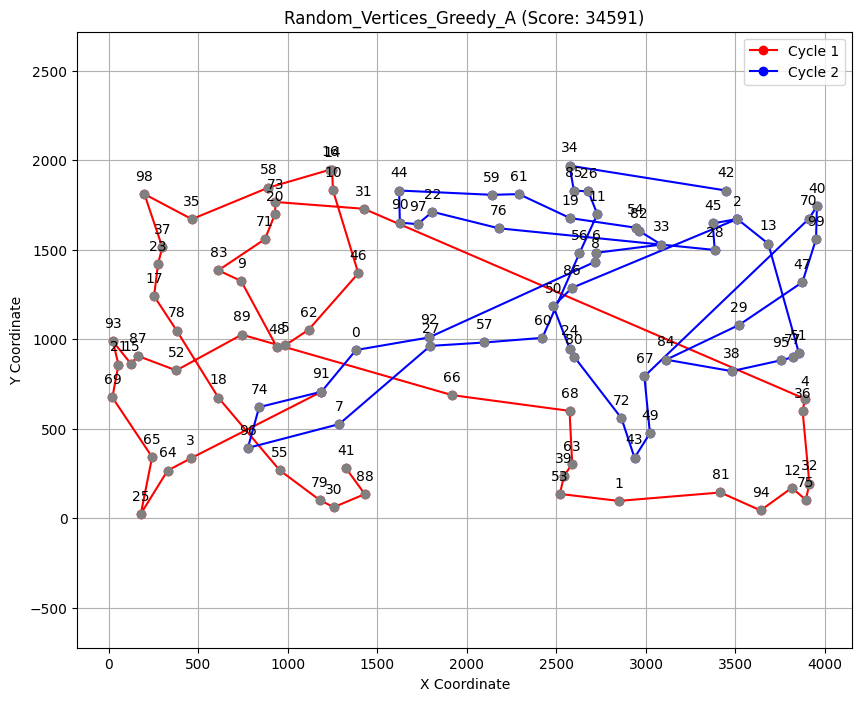

Random_Vertices_Steep_A: ([55, 79, 30, 25, 69, 15, 87, 52, 92, 27, 57, 60, 50, 86, 24, 80, 72, 67, 84, 33, 82, 54, 11, 6, 8, 56, 46, 89, 48, 5, 62, 0, 66, 68, 63, 39, 43, 49, 38, 95, 4, 36, 32, 75, 12, 94, 81, 1, 53, 88, 55], [31, 10, 16, 14, 59, 61, 85, 26, 19, 76, 44, 9, 83, 93, 21, 65, 64, 3, 96, 41, 7, 91, 71, 20, 73, 58, 35, 98, 37, 23, 17, 78, 18, 74, 28, 13, 29, 77, 51, 47, 99, 70, 40, 2, 45, 42, 34, 22, 90, 97, 97])


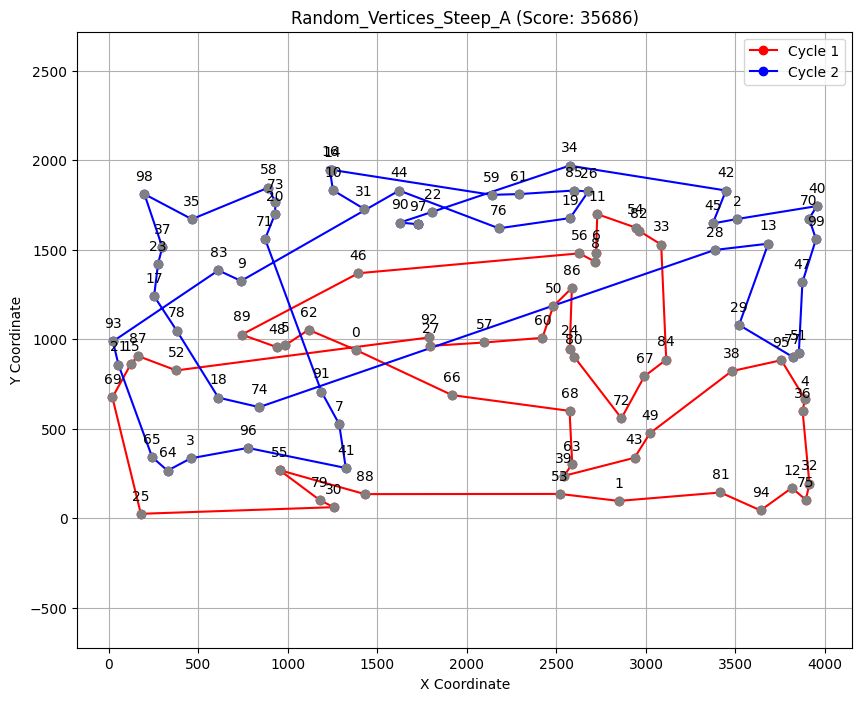

Random_Edges_Greedy_A: ([54, 82, 28, 95, 77, 51, 4, 36, 32, 75, 12, 94, 81, 49, 72, 43, 1, 63, 68, 80, 24, 86, 50, 60, 66, 41, 7, 91, 74, 18, 52, 15, 21, 93, 17, 23, 37, 98, 35, 83, 89, 48, 5, 62, 0, 92, 27, 57, 76, 19, 54], [2, 42, 45, 33, 6, 8, 56, 11, 26, 85, 34, 61, 59, 22, 97, 90, 44, 31, 46, 10, 14, 16, 58, 73, 20, 71, 9, 78, 87, 69, 65, 25, 64, 3, 96, 55, 79, 30, 88, 53, 39, 67, 84, 38, 29, 47, 99, 40, 70, 13, 2])


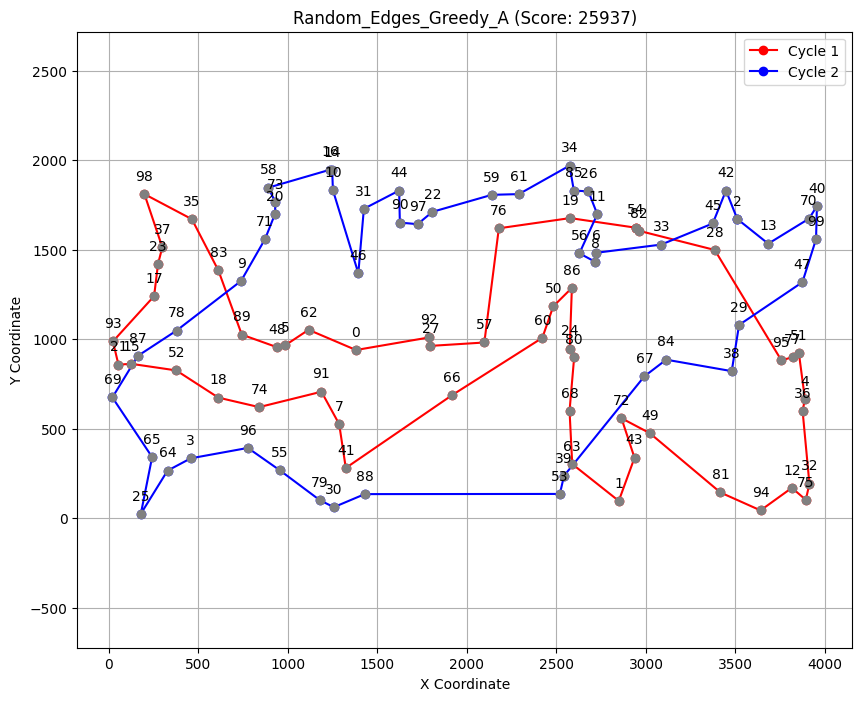

Random_Edges_Steep_A: ([33, 28, 45, 42, 2, 13, 70, 40, 99, 47, 29, 38, 95, 77, 51, 4, 36, 32, 75, 12, 94, 81, 49, 43, 1, 53, 39, 63, 68, 57, 92, 27, 88, 30, 79, 55, 96, 74, 52, 78, 83, 9, 71, 46, 76, 19, 80, 72, 67, 84, 33], [56, 86, 50, 24, 60, 66, 41, 7, 91, 0, 62, 5, 48, 89, 18, 3, 64, 25, 65, 69, 21, 15, 87, 93, 17, 23, 37, 98, 35, 20, 73, 58, 16, 14, 10, 31, 44, 90, 97, 22, 59, 61, 34, 85, 26, 11, 54, 82, 6, 8, 56])


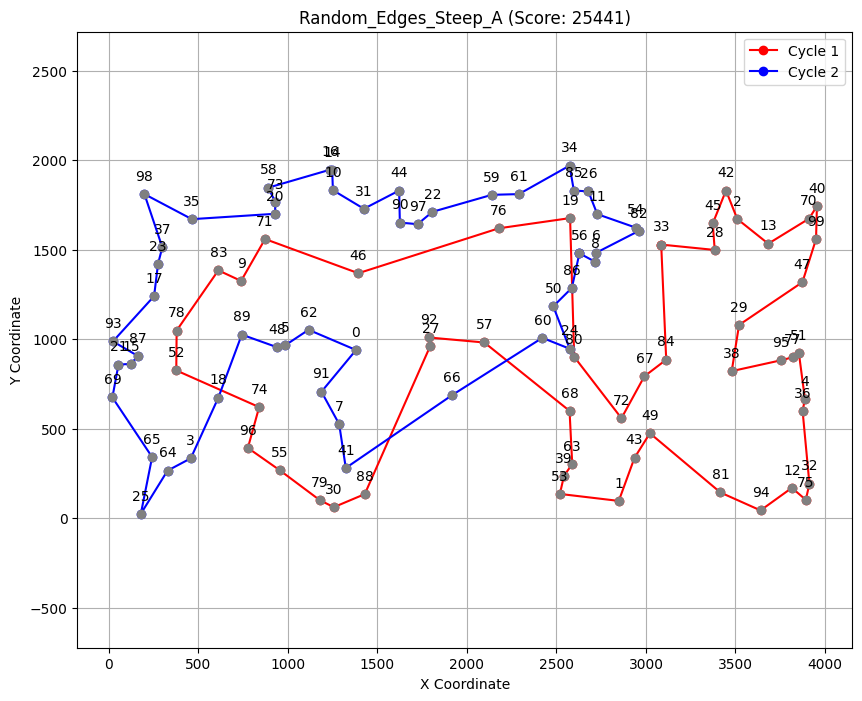

Random_RandomSearch_A: ([35, 96, 62, 92, 10, 97, 16, 9, 40, 75, 70, 66, 84, 34, 6, 63, 25, 50, 86, 43, 90, 21, 91, 31, 1, 47, 55, 65, 72, 68, 89, 82, 33, 3, 59, 38, 85, 15, 64, 67, 39, 36, 24, 27, 83, 78, 52, 7, 61, 79, 35], [23, 32, 73, 48, 5, 29, 49, 14, 99, 4, 77, 46, 20, 56, 42, 12, 87, 80, 88, 93, 44, 94, 22, 28, 41, 58, 60, 37, 19, 2, 57, 26, 53, 30, 18, 17, 74, 69, 98, 54, 95, 76, 11, 51, 8, 13, 45, 0, 81, 71, 23])


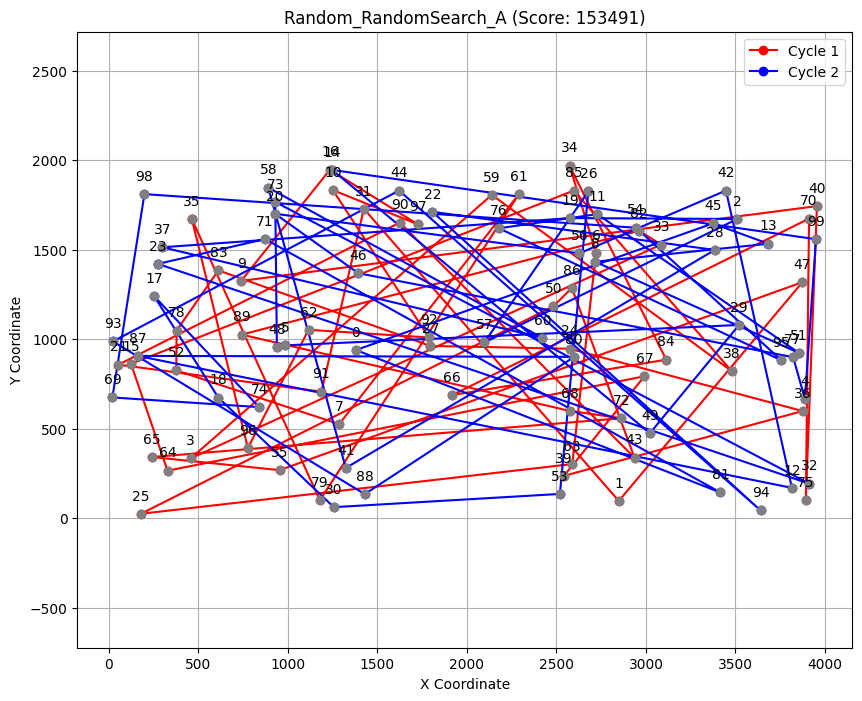

2-regret_Vertices_Greedy_A: ([90, 46, 92, 27, 57, 66, 0, 91, 7, 41, 88, 30, 79, 55, 96, 64, 25, 65, 3, 74, 62, 5, 48, 89, 18, 52, 15, 69, 21, 93, 87, 78, 17, 23, 37, 98, 35, 83, 9, 71, 20, 73, 58, 16, 14, 10, 31, 44, 22, 97, 90], [12, 94, 81, 1, 53, 39, 63, 43, 49, 72, 68, 80, 24, 60, 50, 86, 8, 6, 56, 19, 76, 59, 61, 34, 85, 26, 11, 54, 82, 33, 45, 42, 2, 40, 70, 99, 47, 13, 28, 29, 84, 67, 38, 95, 77, 51, 4, 36, 32, 75, 75])


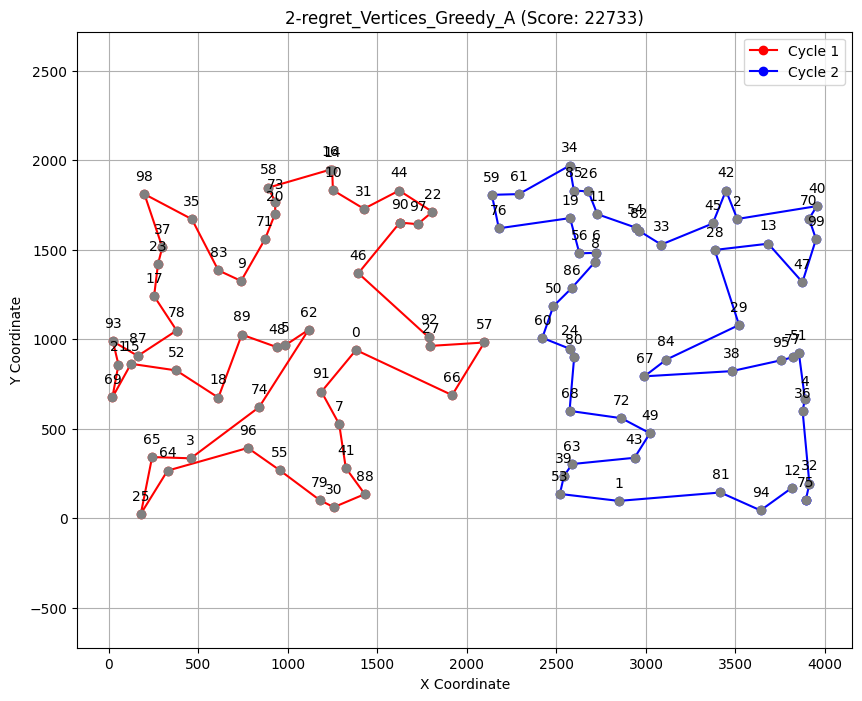

2-regret_Vertices_Steep_A: ([97, 22, 44, 31, 10, 14, 16, 58, 73, 20, 71, 9, 83, 35, 98, 37, 23, 17, 78, 87, 93, 21, 69, 15, 52, 18, 89, 48, 5, 62, 74, 3, 65, 25, 64, 96, 55, 79, 30, 88, 41, 7, 91, 0, 66, 57, 27, 92, 46, 90, 97], [12, 94, 81, 1, 53, 39, 63, 43, 49, 72, 68, 80, 24, 60, 50, 86, 8, 6, 56, 19, 76, 59, 61, 34, 85, 26, 11, 54, 82, 33, 45, 42, 2, 40, 70, 99, 47, 13, 28, 29, 84, 67, 38, 95, 77, 51, 4, 36, 32, 75, 75])


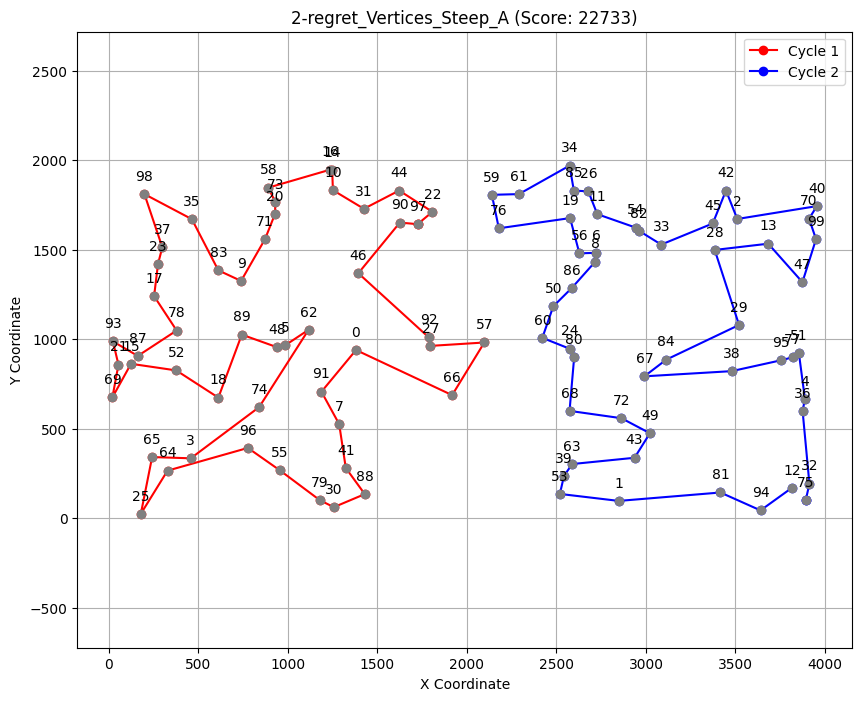

2-regret_Edges_Greedy_A: ([51, 47, 99, 40, 70, 13, 2, 42, 45, 28, 29, 38, 84, 67, 33, 82, 54, 11, 26, 85, 34, 61, 59, 76, 19, 56, 6, 8, 86, 50, 60, 24, 80, 68, 72, 49, 43, 63, 39, 53, 1, 81, 94, 12, 75, 32, 36, 4, 95, 77, 51], [69, 15, 87, 78, 52, 18, 65, 25, 64, 3, 96, 55, 79, 30, 88, 41, 7, 91, 74, 89, 48, 5, 62, 0, 66, 57, 27, 92, 46, 90, 97, 22, 44, 31, 10, 14, 16, 58, 73, 20, 71, 9, 83, 35, 98, 37, 23, 17, 93, 21, 69])


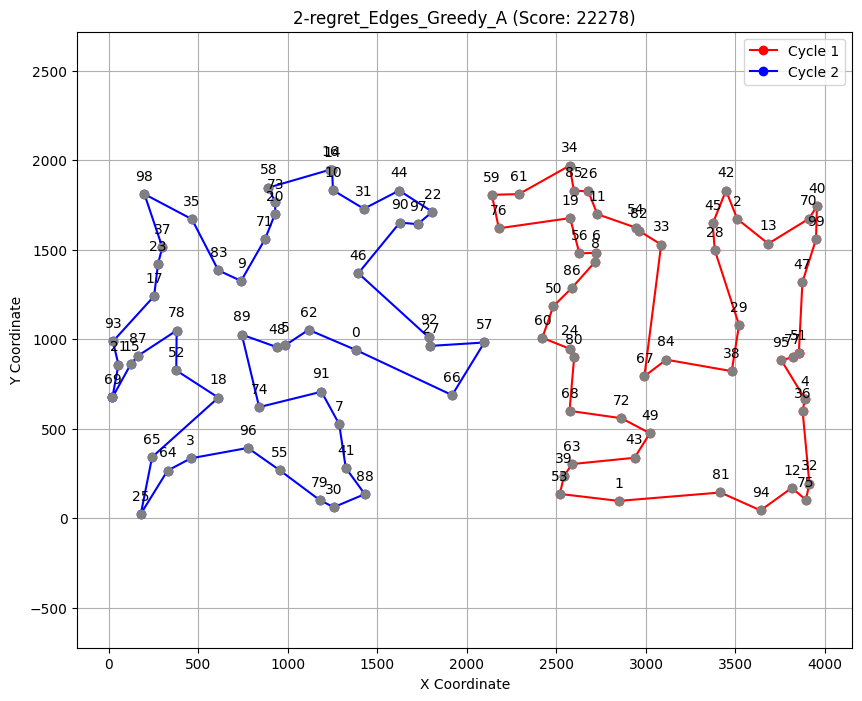

2-regret_Edges_Steep_A: ([36, 32, 75, 12, 94, 81, 1, 53, 39, 63, 43, 49, 72, 68, 80, 24, 60, 50, 86, 8, 6, 56, 19, 76, 59, 61, 34, 85, 26, 11, 54, 82, 33, 67, 84, 38, 29, 28, 45, 42, 2, 13, 70, 40, 99, 47, 51, 77, 95, 4, 36], [93, 17, 23, 37, 98, 35, 83, 9, 71, 20, 73, 58, 16, 14, 10, 31, 44, 22, 97, 90, 46, 92, 27, 57, 66, 0, 62, 5, 48, 89, 74, 91, 7, 41, 88, 30, 79, 55, 96, 3, 64, 25, 65, 18, 52, 78, 87, 15, 69, 21, 93])


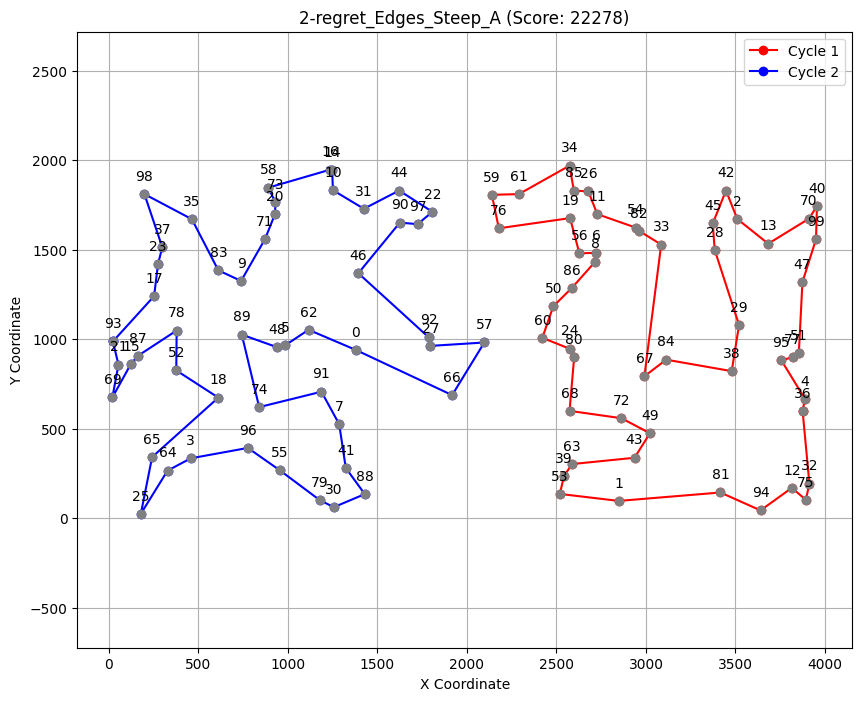

2-regret_RandomSearch_A: ([87, 52, 78, 18, 65, 25, 64, 3, 96, 55, 79, 30, 88, 41, 73, 89, 48, 5, 62, 91, 7, 0, 66, 57, 27, 92, 46, 90, 97, 22, 44, 31, 10, 14, 16, 58, 74, 20, 71, 9, 83, 35, 98, 37, 23, 17, 93, 21, 69, 15, 87], [40, 99, 47, 51, 77, 95, 38, 4, 36, 32, 75, 12, 94, 81, 1, 53, 39, 63, 43, 49, 72, 68, 80, 24, 50, 60, 86, 56, 6, 8, 19, 76, 59, 61, 34, 85, 42, 11, 54, 82, 33, 67, 84, 29, 28, 45, 26, 2, 13, 70, 40])


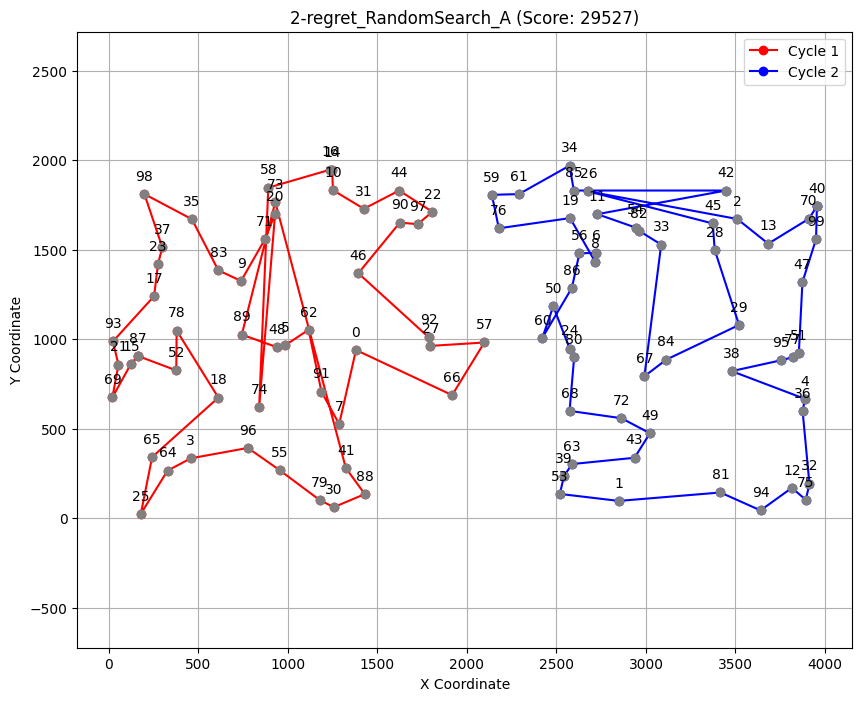

Random_Vertices_Greedy_B: ([61, 99, 55, 45, 70, 11, 31, 28, 2, 97, 94, 0, 89, 20, 85, 29, 74, 37, 19, 79, 78, 80, 46, 53, 42, 86, 65, 34, 58, 75, 7, 98, 96, 90, 27, 10, 92, 84, 72, 52, 69, 38, 25, 68, 48, 67, 9, 39, 4, 66, 66], [82, 3, 5, 81, 41, 1, 13, 63, 32, 14, 50, 47, 30, 62, 12, 77, 16, 35, 44, 17, 23, 76, 49, 60, 26, 33, 87, 22, 21, 54, 95, 91, 18, 43, 40, 15, 88, 73, 56, 93, 8, 24, 71, 64, 36, 6, 83, 57, 51, 59, 59])


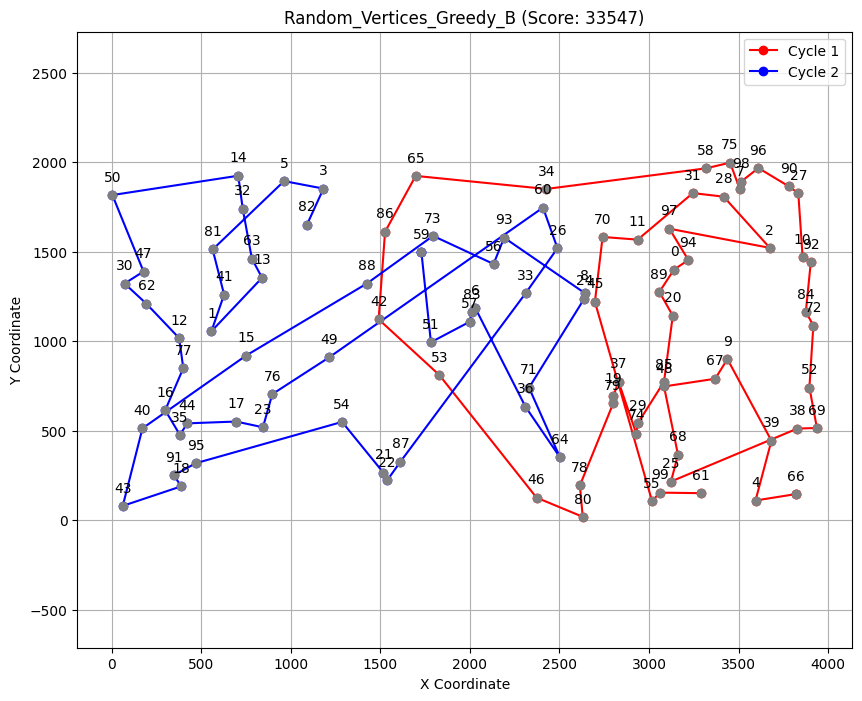

Random_Vertices_Steep_B: ([38, 69, 66, 4, 61, 45, 8, 24, 25, 99, 55, 80, 78, 37, 94, 27, 90, 96, 98, 7, 75, 58, 31, 11, 70, 26, 6, 83, 57, 51, 53, 36, 46, 64, 48, 85, 67, 52, 72, 84, 92, 10, 2, 28, 97, 0, 89, 20, 9, 39, 38], [14, 50, 47, 30, 62, 12, 77, 49, 42, 93, 60, 34, 13, 63, 5, 3, 86, 59, 73, 56, 33, 19, 79, 29, 68, 74, 71, 82, 32, 81, 41, 1, 15, 76, 23, 54, 87, 22, 21, 95, 91, 18, 43, 40, 16, 35, 44, 17, 88, 65, 65])


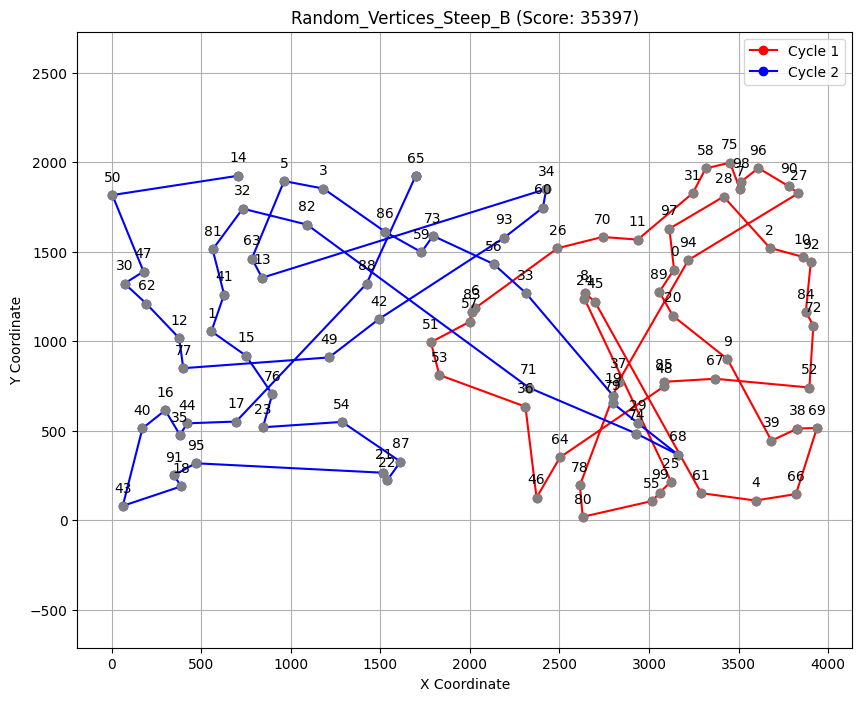

Random_Edges_Greedy_B: ([3, 65, 73, 59, 83, 6, 33, 8, 24, 45, 89, 0, 94, 97, 31, 58, 75, 28, 7, 98, 96, 90, 27, 2, 10, 92, 84, 72, 9, 67, 85, 48, 29, 79, 19, 37, 71, 36, 87, 22, 21, 54, 76, 15, 12, 62, 30, 47, 50, 14, 3], [16, 44, 77, 1, 41, 13, 63, 81, 32, 5, 82, 88, 86, 56, 93, 34, 60, 26, 70, 11, 20, 52, 69, 38, 39, 66, 4, 61, 55, 99, 25, 68, 74, 64, 78, 80, 46, 53, 57, 51, 42, 49, 23, 17, 35, 95, 91, 18, 43, 40, 16])


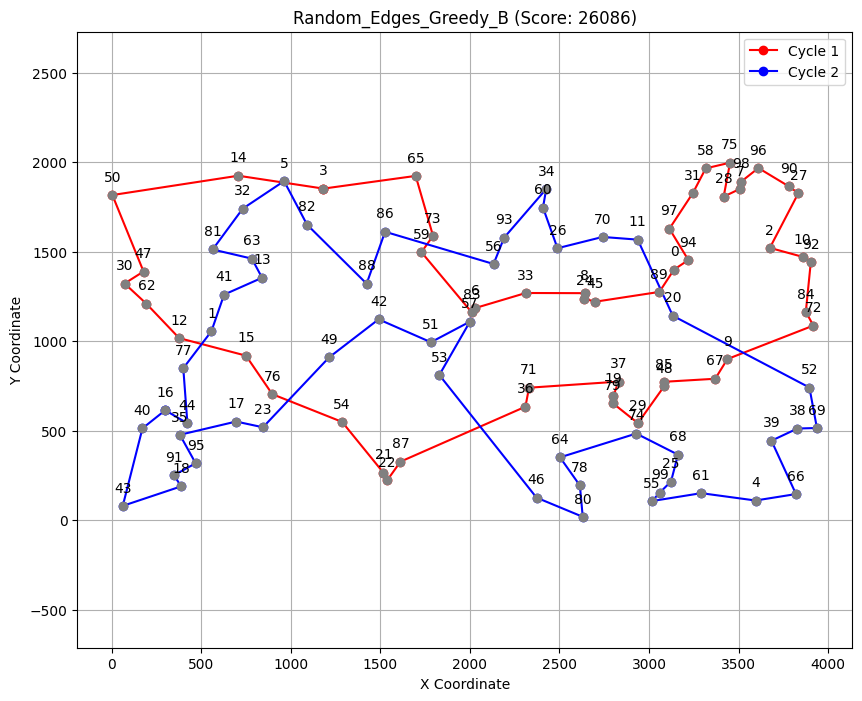

Random_Edges_Steep_B: ([74, 29, 48, 85, 20, 67, 9, 92, 10, 2, 89, 45, 24, 8, 26, 33, 56, 6, 83, 57, 42, 88, 82, 14, 50, 47, 30, 62, 12, 77, 15, 76, 17, 44, 35, 16, 40, 43, 18, 91, 95, 23, 54, 21, 22, 87, 71, 37, 19, 79, 74], [60, 93, 59, 73, 65, 86, 3, 5, 32, 81, 63, 13, 41, 1, 49, 51, 53, 36, 64, 46, 78, 80, 55, 99, 25, 68, 61, 4, 66, 39, 38, 69, 52, 72, 84, 27, 90, 96, 75, 58, 98, 7, 28, 31, 97, 94, 0, 11, 70, 34, 60])


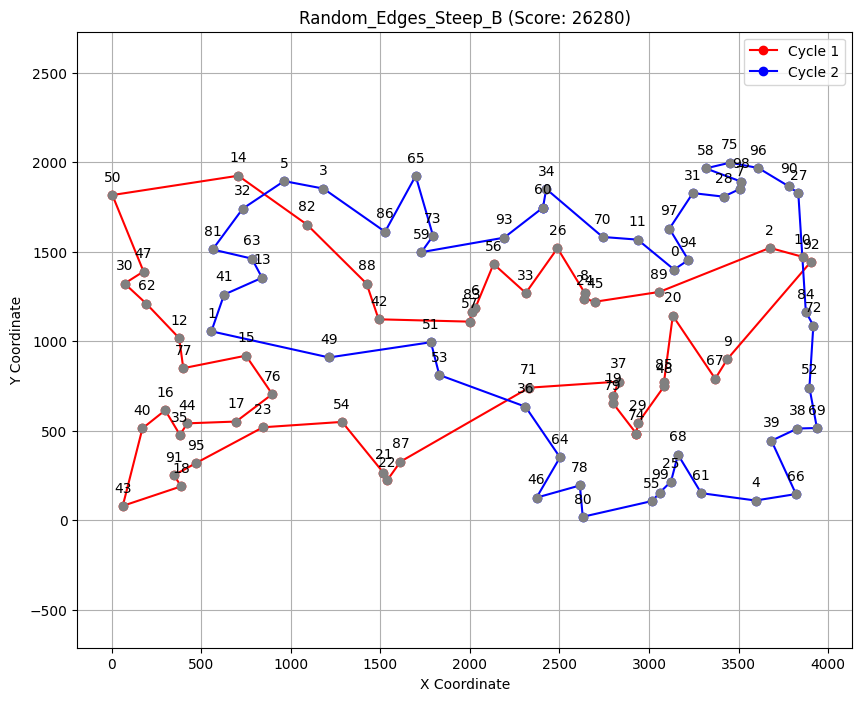

Random_RandomSearch_B: ([34, 28, 19, 31, 61, 7, 38, 24, 99, 96, 23, 3, 80, 73, 77, 45, 56, 70, 55, 62, 94, 74, 87, 50, 30, 76, 83, 40, 46, 86, 57, 14, 88, 16, 97, 39, 89, 65, 21, 20, 18, 78, 1, 91, 85, 92, 48, 44, 68, 71, 34], [10, 52, 84, 64, 17, 25, 98, 11, 51, 72, 0, 58, 49, 82, 47, 41, 22, 53, 95, 93, 13, 33, 79, 37, 36, 6, 12, 15, 32, 81, 43, 26, 59, 4, 69, 8, 63, 5, 35, 60, 27, 75, 54, 29, 66, 90, 42, 2, 9, 67, 10])


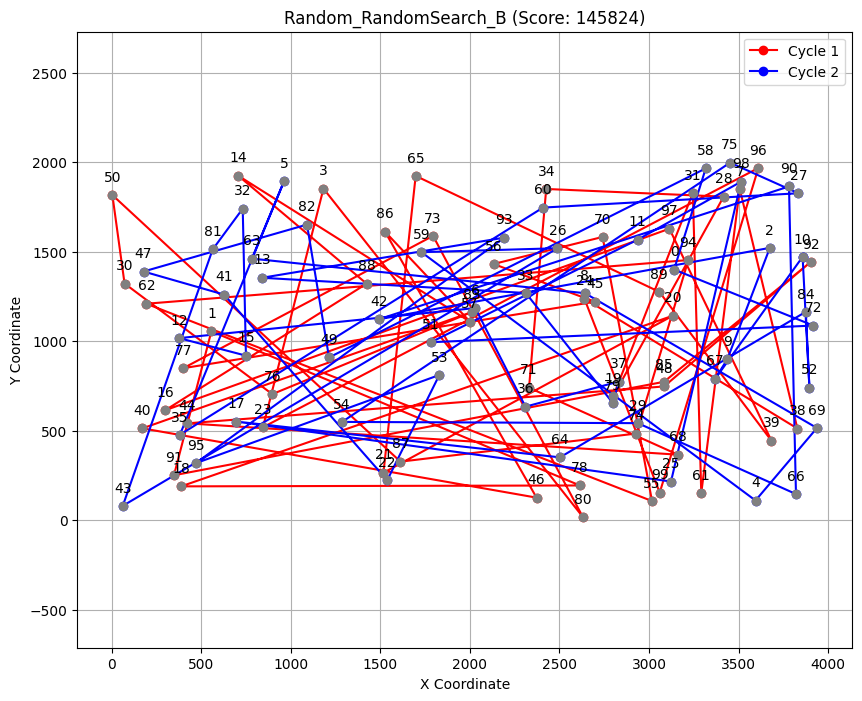

2-regret_Vertices_Greedy_B: ([5, 14, 32, 81, 50, 47, 30, 62, 12, 77, 16, 40, 43, 18, 91, 95, 35, 44, 17, 23, 54, 21, 22, 87, 46, 80, 78, 64, 36, 71, 6, 83, 57, 53, 51, 42, 49, 76, 15, 1, 41, 13, 63, 82, 88, 86, 59, 73, 65, 3, 5], [66, 39, 38, 69, 52, 72, 84, 92, 10, 2, 27, 90, 96, 98, 7, 28, 75, 58, 31, 97, 70, 26, 60, 34, 93, 56, 33, 8, 24, 45, 11, 94, 0, 89, 20, 9, 67, 85, 48, 37, 19, 79, 29, 74, 68, 25, 99, 55, 61, 4, 66])


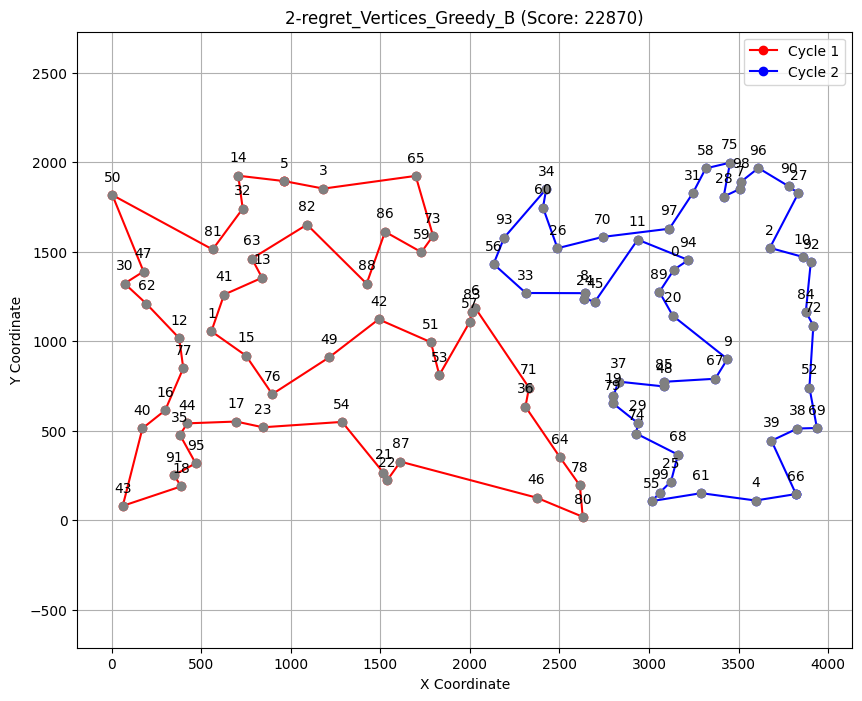

2-regret_Vertices_Steep_B: ([65, 3, 5, 14, 32, 81, 50, 47, 30, 62, 12, 77, 16, 40, 44, 35, 91, 43, 18, 95, 17, 23, 54, 21, 22, 87, 46, 80, 78, 64, 36, 71, 6, 83, 57, 53, 51, 42, 49, 76, 15, 1, 41, 13, 63, 82, 88, 86, 59, 73, 65], [66, 39, 38, 69, 52, 72, 84, 92, 10, 2, 27, 90, 96, 98, 7, 28, 75, 58, 31, 97, 70, 34, 60, 93, 56, 33, 26, 8, 24, 45, 11, 94, 0, 89, 20, 9, 67, 85, 48, 37, 19, 79, 29, 74, 68, 25, 99, 55, 61, 4, 66])


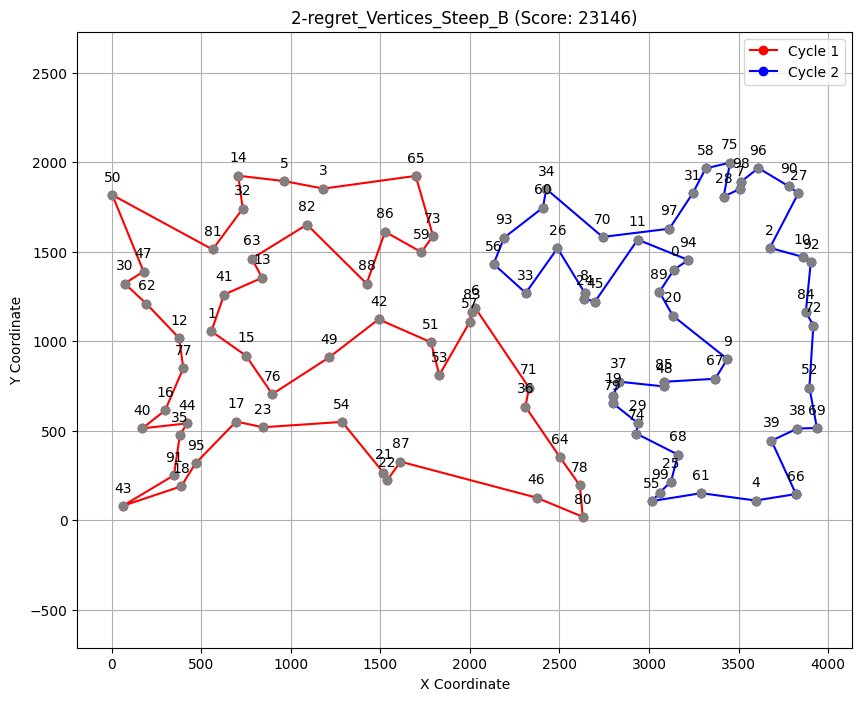

2-regret_Edges_Greedy_B: ([59, 86, 88, 42, 51, 53, 57, 83, 6, 71, 36, 64, 78, 80, 46, 87, 22, 21, 54, 49, 15, 76, 23, 17, 95, 91, 18, 43, 40, 35, 44, 16, 77, 1, 12, 62, 30, 47, 50, 81, 41, 13, 63, 82, 32, 14, 5, 3, 65, 73, 59], [66, 39, 38, 69, 52, 72, 84, 92, 10, 2, 27, 90, 96, 98, 7, 28, 75, 58, 31, 97, 11, 70, 34, 60, 93, 56, 33, 26, 8, 24, 45, 89, 0, 94, 20, 9, 67, 85, 48, 37, 19, 79, 29, 74, 68, 25, 99, 55, 61, 4, 66])


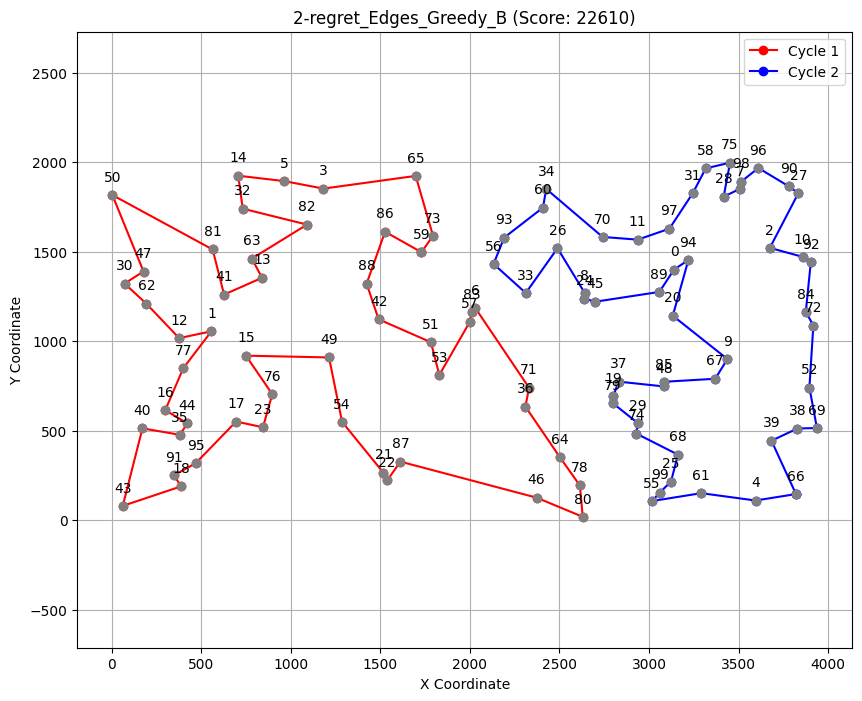

2-regret_Edges_Steep_B: ([62, 12, 77, 16, 40, 43, 18, 91, 95, 35, 44, 17, 23, 76, 54, 21, 22, 87, 46, 80, 78, 64, 36, 71, 6, 83, 57, 53, 51, 42, 49, 15, 1, 41, 13, 63, 82, 88, 86, 59, 73, 65, 3, 5, 14, 32, 81, 50, 47, 30, 62], [69, 52, 72, 84, 92, 10, 2, 27, 90, 96, 98, 7, 28, 75, 58, 31, 97, 94, 0, 11, 70, 34, 60, 93, 56, 33, 26, 8, 24, 45, 89, 20, 9, 67, 85, 48, 37, 19, 79, 29, 74, 68, 25, 99, 55, 61, 4, 66, 39, 38, 69])


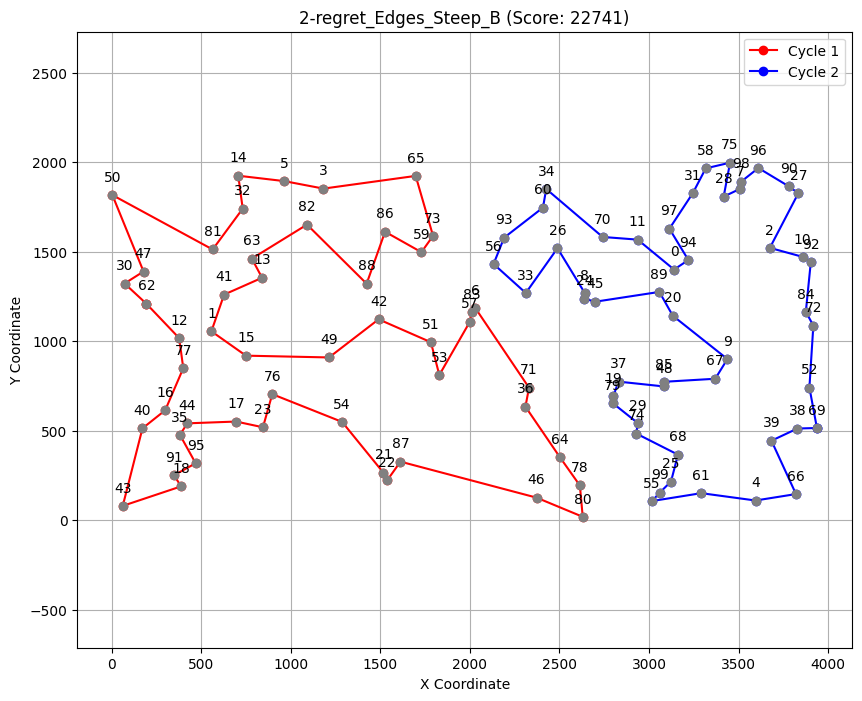

2-regret_RandomSearch_B: ([52, 72, 84, 92, 10, 2, 27, 90, 96, 98, 7, 93, 59, 73, 86, 65, 60, 26, 70, 97, 31, 58, 75, 28, 34, 8, 11, 94, 0, 89, 20, 9, 67, 85, 48, 37, 19, 79, 29, 74, 68, 25, 99, 55, 61, 4, 66, 39, 38, 69, 52], [50, 62, 30, 47, 12, 77, 16, 40, 44, 35, 91, 43, 18, 95, 17, 23, 76, 54, 21, 22, 87, 46, 80, 78, 64, 36, 71, 45, 24, 33, 56, 6, 83, 57, 53, 51, 42, 88, 32, 5, 3, 82, 13, 63, 81, 41, 1, 15, 49, 14, 50])


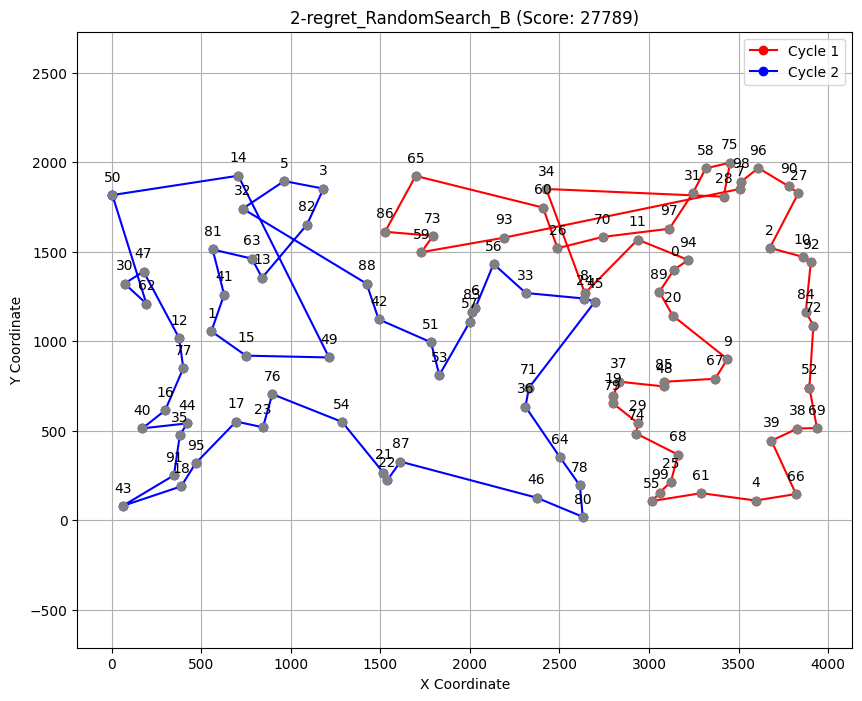

In [10]:
# Plotting best cycles for each combination\
best_cycles = {**best_cycles_A, **best_cycles_B}

for key, value in best_cycles.items():
    print(key + ":", value)
    best_cycle1, best_cycle2 = value
    if "A" in key:
        score = calculate_score(best_cycle1, best_cycle2, distance_matrix_A)
        plot_cycles(data_kroA100, best_cycle1, best_cycle2, title=f"{key} (Score: {score})")
    elif "B" in key:
        score = calculate_score(best_cycle1, best_cycle2, distance_matrix_B)
        plot_cycles(data_kroB100, best_cycle1, best_cycle2, title=f"{key} (Score: {score})")

In [11]:
df_results_A

,Starting cycles,Neighbourhood,Method,Min,Max,Mean,Min Time,Max Time,Mean Time
0,Random,Vertices,Greedy,34591,53212,42619.50,1.413060,2.544874,2.037524
1,Random,Vertices,Steep,35686,56783,44288.85,0.561871,1.091928,0.758007
2,Random,Edges,Greedy,25937,31794,28322.06,1.326293,1.893476,1.632402
3,Random,Edges,Steep,25441,31073,28134.38,0.452118,0.596820,0.522132
4,Random,-,Random search,153491,191572,171116.85,0.522174,0.563316,0.536456
5,2-regret,Vertices,Greedy,22733,28008,25558.69,0.010439,0.186292,0.081892
6,2-regret,Vertices,Steep,22733,27447,25500.45,0.011129,0.112948,0.059983
7,2-regret,Edges,Greedy,22278,27941,25060.38,0.018308,0.155076,0.073478
8,2-regret,Edges,Steep,22278,27380,24789.79,0.017611,0.099121,0.057288
9,2-regret,-,Random search,29527,63244,43775.48,0.060669,0.096404,0.072269


In [12]:
df_results_B

,Starting cycles,Neighbourhood,Method,Min,Max,Mean,Min Time,Max Time,Mean Time
0,Random,Vertices,Greedy,33547,51716,42799.95,1.511669,2.495910,1.968232
1,Random,Vertices,Steep,35397,53864,44434.21,0.512338,0.939039,0.713906
2,Random,Edges,Greedy,26086,32699,29073.44,1.275954,1.996860,1.596114
3,Random,Edges,Steep,26280,31653,28917.04,0.438531,0.602788,0.517051
4,Random,-,Random search,145824,184921,169572.32,0.517260,0.559660,0.531988
5,2-regret,Vertices,Greedy,22870,28569,25796.46,0.012510,0.200887,0.075673
6,2-regret,Vertices,Steep,23146,28270,25682.73,0.022533,0.107889,0.059849
7,2-regret,Edges,Greedy,22610,28419,25614.90,0.018214,0.164077,0.081776
8,2-regret,Edges,Steep,22741,28237,25380.55,0.017179,0.098478,0.064917
9,2-regret,-,Random search,27789,59344,44529.79,0.064933,0.095176,0.073936


In [13]:
df_results_A.to_csv('results_A.csv', index=False)
df_results_B.to_csv('results_B.csv', index=False)